In [1]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

import matplotlib
# matplotlib.use('GTKAgg')
import matplotlib.pyplot as plt
%matplotlib inline

import librosa, librosa.display

import time, operator
# import pylab as pl
from IPython import display

from io import BytesIO
from PIL import Image

import torch
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets as dset

import sys
sys.path.append('../../src/')
from deepdream import util as ddutil
from deepdream import resnet as ddresnet
from deepdream.deepdream import dream, objective_L2, objective_deepdream, objective_channel, objective_guide

In [2]:
def stream_spectrogram(sound_in, sr):
    
    y = sound_in
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    buffer_ = BytesIO()
    
    plt.ioff()
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
    plt.axis('off') # Removes black border
    plt.tight_layout()
    plt.savefig(buffer_,bbox_inches='tight',pad_inches=-0.05,transparency=True, format='jpg')
    image = Image.open(buffer_)
    plt.close()
    buffer_.seek(0)
    #ar = np.asarray(image)
    return image, S
    buffer_.close()
    
def classify_sound(image,classification_model):
    
    classification_model.eval()
    predictions = {}
    # Try your own image here.
    inputVar =  Variable(transform(image).unsqueeze(0))
    predictions = classification_model(inputVar.cpu())

    probs, indices = (-F.softmax(predictions.cpu())).data.sort()
    probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
    #print(probs)
    preds = {class_dict[idx]:prob for (prob, idx) in zip(probs,indices)}
    preds = sorted(preds.items(), key=operator.itemgetter(1), reverse=True)
    
    #preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
    #print(preds)
    #plt.title('\n'.join(preds))
    #plt.imshow(image);
    return preds

def render_predictions(preds,class_colors):
    fig, ax = plt.subplots(figsize=(6,4),dpi=65)
    vals = [preds[p][1] for p in range(0, len(preds))]
    labls = [preds[p][0].replace('_',' ').title() for p in range(0, len(preds))]
    colors = [class_colors[preds[p][0]] for p in range(0, len(preds))]
    ax.barh(labls,vals,align='center',color=colors)
    ax.invert_yaxis()
    ax.set_xlabel('Probability')
    ax.set_title('Predicted class')
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In [3]:
# ResNet Sound2Image
# ------

from deepdream import resnet as ddresnet


try:
    reload(ddresnet)
except:
    from deepdream import resnet as ddresnet

# Load true image of resnet for eval
# model = torch.nn.DataParallel(model, device_ids=[0, 1])
#sound2image_local=True
eval_model = models.resnet50(pretrained=True)
# You must reduce output dim before loading weights
eval_model.fc = nn.Linear(eval_model.fc.in_features, 10)
print(eval_model.fc)


eval_weights_src = ['../../data/models/resnet50_v2_melspect_15_968.pt']
# eval_weights_src = ['../../results/model/model.pt']
eval_model.load_state_dict(torch.load(eval_weights_src[0],
                                      map_location=lambda storage, loc: storage))

#dream_model = ddresnet.resnet50(sound2image=True,local=True) # for spectrograms
dream_model = ddresnet.resnet50(pretrained=True) # for use on pre-selected images
dream_model = dream_model.cpu()
for param in dream_model.parameters():
    param.require_grads = False
    
# If pretrained=True
dream_model.fc = nn.Linear(dream_model.fc.in_features, 10)

print(dream_model.fc)

Linear(in_features=2048, out_features=10)
Linear(in_features=2048, out_features=10)


In [4]:
class_dict = {0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jack_hammer',
 8: 'siren',
 9: 'street_music'}

class_colors = {"air_conditioner":"#0164cd",
                "car_horn":"#00a069",
                "children_playing":"#e44caa",
                "dog_bark":"#c2c331",
                "drilling":"#00b4f5",
                "engine_idling":"#007008",
                "gun_shot":"#b00036",
                "jack_hammer":"#bfa2ff",
                "siren":"#c35d03",
                "street_music":"#ff8765"
               }

In [5]:
# class_img_path = './deepdream/data/base/render_classes/'
class_img_path = '../../src/deepdream/data/render_classes_old/'
img_id = 0

dream_transform = transforms.Compose([
    transforms.Scale((300)),
    transforms.CenterCrop(224),
    transforms.Scale((300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dream_set = dset.ImageFolder(class_img_path,transform=dream_transform)

dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
deepdream_img_dict = dset_loader.dataset.class_to_idx

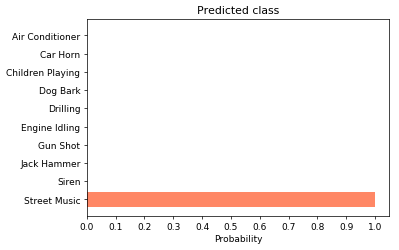

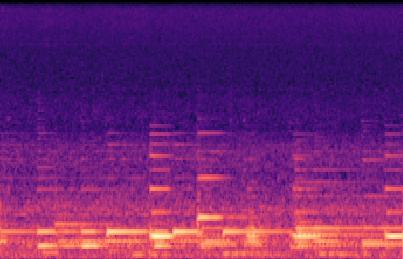

In [7]:
duration = 4
sr=44100

plot_predictions = True
display_spect = True

transform = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Deepdream parameters
dream_transform = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
use_deepdream = False

deep_spect = False
fixed_class_images = True

dream_dict = {}
dream_dict['ars_test'] = {'zoom_interval':10,'nproll':None,'zoom_orientation':'center','fade_alpha':0.1,
                          'octave_n':1,'num_iterations': 1,'lr':0.25,'max_jitter':10,'show_every':1,
                          'end_layer':3,'neuron_unit':5,
                          'stream_out':False,'zoom_echo':False,'awaken':False,'awaken_alpha':0.0}

dict_target = 'ars_test'
filepath = None
total_frames = 1 # number of zoom steps
write_out = False
guide_features = None

sound_time = []
spect_time = []
model_time = []

# t0 = time.time()
#while True:
for i in range(60):
    try:
        display.clear_output(wait=True)
        
        # ----------------------- #
        # Input: Sampling sound
        # ----------------------- #
        
        # THREAD: Creating an audio sample
        # ----------
        t0 = time.time()
        
        mic_recording = sd.rec(int(duration * sr), samplerate=sr, channels=2,dtype='float64')
        sd.wait()
        
        tn = time.time()
        #print("Sound sample",tn-t0)
        sound_time.append(tn-t0)
        # ----------
        
        # ------------------------- #
        # Processing: Classify sound
        # ------------------------- #
        
        # THREAD: Sample sound, spectrogram, and classify
        # ----------
        
        t0 = time.time()
        
        spect,s = stream_spectrogram(mic_recording[:,0],sr)
        
        tn = time.time()
        #print("Create spectrogram",tn-t0)
        spect_time.append(tn-t0)
        
        
        t0 = time.time()
        
        preds = classify_sound(spect,eval_model)
        
        tn = time.time()
        #print("Classify sound",tn-t0)
        model_time.append(tn-t0)
        # ----------
          
            
        # ----------------------- #
        # Rendering visualization
        # ----------------------- #
        
        vals = [preds[p][1] for p in range(0, len(preds))]
        labls = [preds[p][0] for p in range(0, len(preds))]
        predicted_class = labls[0]
        
        f1 = open('../../data/preds_file.txt', "wt")
        f1.write(predicted_class)
        f1.flush()
        
        #return_img = preds[0][0]
        #dd_idx = deepdream_img_dict[return_img]
        #input_np = dset_loader.dataset[dd_idx][0].unsqueeze(0).numpy()
        #input_np = transform(spect).unsqueeze(0).numpy()
        
        # THREAD: Deep dream visualization
        # ----------

        if use_deepdream:
        
            if deep_spect: 
                #input_np = transform(spect).unsqueeze(0).numpy()
                input_np = dream_transform(spect).unsqueeze(0).numpy()
            else:
                # Select image
                if fixed_class_images:
                    return_img = preds[0][0]
                    dd_idx = deepdream_img_dict[return_img]
                    input_np = dset_loader.dataset[dd_idx][0].unsqueeze(0).numpy()
                #         inputs_guide = dset_loader.dataset[dd_idx][0].unsqueeze(0)

            dream(dream_model, input_np,
                  zoom_depth=total_frames,
                  file_path=filepath,
                  write=write_out,
                  zoom_interval=dream_dict[dict_target]['zoom_interval'],
                  zoom_orientation=dream_dict[dict_target]['zoom_orientation'],
                  nproll=dream_dict[dict_target]['nproll'],
                  fade_alpha=dream_dict[dict_target]['fade_alpha'],
                  octave_n=dream_dict[dict_target]['octave_n'], 
                  num_iterations=dream_dict[dict_target]['num_iterations'], 
                  lr=dream_dict[dict_target]['lr'],
                  max_jitter=dream_dict[dict_target]['max_jitter'],
                  show_every=dream_dict[dict_target]['show_every'],
                  end_layer=dream_dict[dict_target]['end_layer'],
                  neuron_unit=dream_dict[dict_target]['neuron_unit'],
                  stream_out=dream_dict[dict_target]['stream_out'],
                  zoom_echo=dream_dict[dict_target]['zoom_echo'],
                  awaken=dream_dict[dict_target]['awaken'],
                  awaken_alpha=dream_dict[dict_target]['awaken_alpha'],
                  objective=objective_channel,
                  guide_features = guide_variable,
                  use_gpu = False,
                  clear_out = True
                 )
                
        
        # THREAD: Rendering predictions plot
        # This goes second because the deep dream clears the canvas
        # ----------
        if plot_predictions:
            render_predictions(preds,class_colors)
        if display_spect:
            display.display(spect)
        # ---------
        
        time.sleep(.0001)
    except KeyboardInterrupt:
        break
        
# tn = time.time()
# print(tn-t0)